# Datos de corrientes
Este documento se centra sobre la lectura y la representación de datos de corrientes en oceanografía.
![Captura de pantalla de https://earth.nullschool.net](img/currents.png)

La figura es una captura de pantalla de https://earth.nullschool.net, donde observamos las corrientes en el Pacífico Ecuatorial, a una profundidad de 5 metros.

## Cómo se miden las corrientes?       

Existen varias maneras de medir las corrientes a la superficie del océano (mientras la estimación de la velocidad a varias profundidades resulta más complejo)

- con **boyas de derivas** (_drifting buoys_): proporcionan una serie de posiciones, adquiridas por satélite, que permiten estimar la corriente de superficie;
- con un **radar de alta frecuencia** (_HF radar_): proporcionan las corrientes en una zona determinada, gracias a un sistema de antenas;
- con **satélites de altimetría**: las misiones de altimetría proporcionan medidas de anomalías del nivel del mar (_sea level anomalies_), y a partir de ellas se puede derivar las corrientes geostróficas.
- con un **Perfilador Acústico de corrientes Doppler** (_Acoustic Doppler Current Profiler_, ADCP): mide la velocidad a varias distancias del sensor.

In [19]:
import os
import numpy as np
from urllib.request import urlretrieve 
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
mainproj = ccrs.Mercator(central_longitude=-30.0, min_latitude=-20.0, max_latitude=20.0)
datacrs = ccrs.PlateCarree()

## 1. Datos in situ (TBC)
Trabajamos con plataformas in situ obtenidos desde la web de Copernicus Marine Service.

In [2]:
indexlatest = "./index_latest.txt"

In [3]:
indexdata = pd.read_csv(indexlatest, sep=",", header=5)

In [54]:
domain = [-140., -70., -20., 20.]
lon = indexdata["geospatial_lon_min"].values
lat = indexdata["geospatial_lat_min"].values

goodcoords = np.where( (lon<=domain[1]) & (lon>=domain[0]) & (lat<=domain[3]) & (lat>=domain[2]))[0]

In [5]:
indexdata["file_name"][goodcoords].values

array(['INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/cmems_obs-ins_glo_phy-cur_nrt_drifter_irr_202311/latest/20241016/GL_TS_DC_1301622_20241016.nc',
       'INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/cmems_obs-ins_glo_phy-cur_nrt_drifter_irr_202311/latest/20241017/GL_TS_DC_1301622_20241017.nc',
       'INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/cmems_obs-ins_glo_phy-cur_nrt_drifter_irr_202311/latest/20241018/GL_TS_DC_1301622_20241018.nc',
       ...,
       'INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/cmems_obs-ins_glo_phy-cur_nrt_drifter_irr_202311/latest/20241029/GL_TS_DC_7810381_20241029.nc',
       'INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/cmems_obs-ins_glo_phy-cur_nrt_drifter_irr_202311/latest/20241030/GL_TS_DC_7810381_20241030.nc',
       'INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/cmems_obs-ins_glo_phy-cur_nrt_drifter_irr_202311/latest/20241031/GL_TS_DC_7810381_20241031.nc'],
      dtype=object)

## 2. Modelo
https://data.marine.copernicus.eu/product/GLOBAL_ANALYSISFORECAST_PHY_001_024/description

![Selección de datos desde Copernicus Marine](img/CMEMSdownload.png)

### Fichero de datos

In [6]:
currentfile = "cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_1731678780714.nc"
if not(os.path.exists(currentfile)):
    urlretrieve("https://dox.uliege.be/index.php/s/mZLCV3TIbqr1Vqw/download", currentfile)

### Lectura

In [9]:
datacurrent = xr.open_dataset(currentfile)
datacurrent

<xarray.Dataset> Size: 3MB
Dimensions:    (time: 1, depth: 1, latitude: 481, longitude: 840)
Coordinates:
  * time       (time) datetime64[ns] 8B 2024-11-24
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 2kB -20.0 -19.92 -19.83 ... 19.83 19.92 20.0
  * longitude  (longitude) float32 3kB -140.0 -139.9 -139.8 ... -70.17 -70.08
Data variables:
    uo         (time, depth, latitude, longitude) float32 2MB ...
    vo         (time, depth, latitude, longitude) float32 2MB ...
Attributes:
    Conventions:       CF-1.11
    title:             daily mean fields from Global Ocean Physics Analysis a...
    institution:       Mercator Ocean International
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    source:            MOI GLO12
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    references:        http://marine.copernicus.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_ANALYSISFORECAST_PHY_001_024
    subset:datasetId:  cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_202406
    subset:date:       2024-11-15T13:53:00.715Z

### Por componente

In [ ]:
llon, llat = np.meshgrid(datacurrent["longitude"].values, datacurrent["latitude"].values)
uo =  datacurrent["uo"][0,0,:,:]
vo =  datacurrent["vo"][0,0,:,:]
magnitude = (u ** 2 + v ** 2) ** 0.5

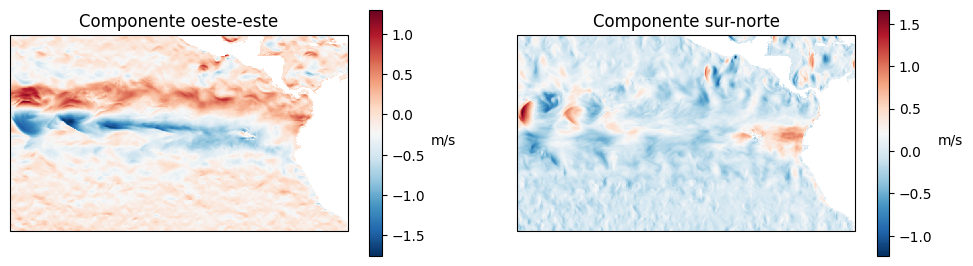

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(121, projection=mainproj)
pcm1 = ax1.pcolormesh(datacurrent["longitude"], datacurrent["latitude"], uo, transform=datacrs, cmap=plt.cm.RdBu_r)
ax1.set_title("Componente oeste-este")
cb1 = plt.colorbar(pcm1, shrink=0.4)
cb1.set_label("m/s", rotation=0, ha="left")

ax2 = plt.subplot(122, projection=mainproj)
pcm2 = ax2.pcolormesh(datacurrent["longitude"], datacurrent["latitude"], vo, transform=datacrs, cmap=plt.cm.RdBu_r)
ax2.set_title("Componente sur-norte")
cb2 = plt.colorbar(pcm2, shrink=0.4)
cb2.set_label("m/s", rotation=0, ha="left")
plt.show()

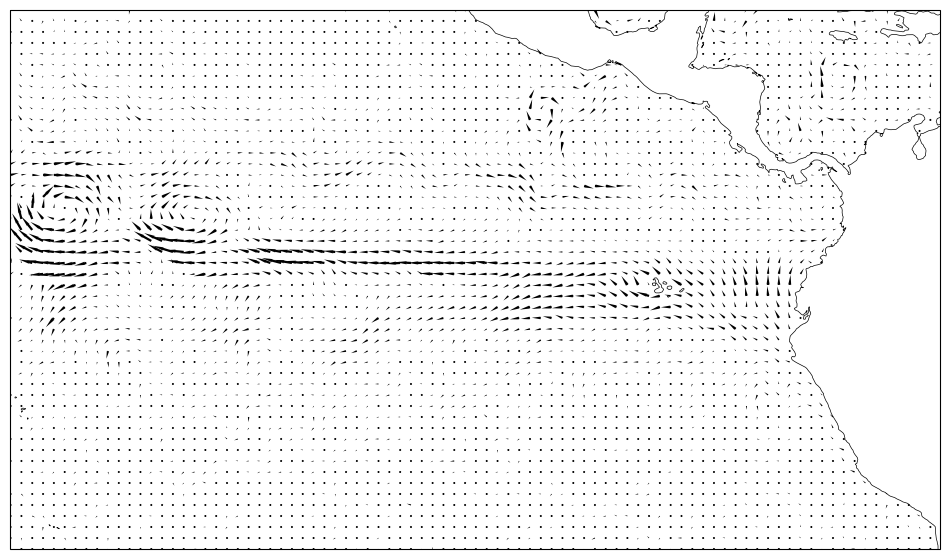

In [63]:
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(111, projection=mainproj)
pcm1 = ax1.quiver(datacurrent["longitude"].values, datacurrent["latitude"].values, uo, vo, 
                  regrid_shape=50, transform=datacrs, headwidth=1.5)
ax1.set_extent(domain)
ax1.coastlines(lw=.5)

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=mainproj)
ax.streamplot(datacurrent["longitude"].values, datacurrent["latitude"].values, uo, vo, transform=vector_crs,
                  linewidth=2, density=2, color=magnitude)

## Qué podemos hacer con datos de corriente?
### Simulaciones de trayectorias

### Eddy tracking